In [1]:
import pandas as pd
import numpy as np
import os
import CLAMS_parsers as parser
import bouts_from_data as bfd
import helpers
import matplotlib.pyplot as plt

# Build time series dataframe

In [2]:
reload(bfd)
reload(helpers)

data_path = 'data_to_process/'
file_list = os.listdir(data_path)

amt_max = 4
dur_max = 1000
rate_max = 0.02
dur_min = 4

dfs = []
file_data = []
for data_file in file_list:
    #print '--- New file ---'
    ## Skip if non-CSV file
    if data_file[-3:] != 'CSV':
        continue
        
    ## Get cage id to tage data with
    cage_id = int(data_file.split('.')[1][-2:])
    
    ## Load raw event data
    num_id, subject_id, mass, data = parser.parse_bouts(data_path+data_file)
    data = np.array(data)

    ## Clean the data, removing cancelling and spurious readings
    cancel_count, data = helpers.remove_cancellations(data)
    neg_count, data = helpers.remove_negatives(data)
    outlier_count, data = helpers.remove_outliers(data, amt_max, dur_max, rate_max, dur_min)
    file_data.append([data_file, cancel_count, neg_count, outlier_count, len(data)])

    ## Get stomach fullness values for events
    ## skipping if all data removed
    if len(data) == 0:
        #print 'No data in %s' %(data_file)
        continue
        
    bouts = bfd.get_events(data)
    
    ## Store time series as dataframe, append to dataframe list
    column_list = ['f_length',
                   'g_start',
                   'rate',
                   'p_length',
                   'g_end_feeding',
                   'period',
                   't_from_start',
                   'start_ts',
                   'end_ts',
                   'amount']
    
    bouts = pd.DataFrame(bouts, columns=column_list)
    bouts['cage_id'] = cage_id
    bouts['num_errs'] = cancel_count + neg_count + outlier_count
    bouts['filename'] = data_file
    dfs.append(bouts)
    
data = pd.concat(dfs, ignore_index=True)

# Create experiment dataframe

In [3]:
coding_file = 'coding.csv'

dtypes = {'date':'str',
          'rat':'int',
          'cage':'int',
          'time':'str',
          'duration':'int',
          'drug':'str',
          'dose':'float',
          'adlib':'str', 
          'period':'str'}

parse_dates = {'start_time':['time', 'date']}

def date_parser(time, date):
    if len(time) == 3:
        time = '0' + time
    
    return pd.datetime.strptime(time+date, '%H%M%d/%m/%y')
#date_parser = lambda x, y: pd.datetime.strptime(x+y, '%-H%M %d/%m/%y')

coding = pd.read_csv(coding_file, dtype=dtypes, parse_dates=parse_dates, date_parser=date_parser)

# Select cutoffs to rule out erroneous data

In [4]:
## Set cutoffs
cancel_cutoff = 25
neg_cutoff = 200
out_cutoff = 45
min_bouts = 5

## Sort on total number of errors in order to make it easy
## to cross-reference worst looking files against time series
sorted_files = sorted(file_data, 
                      key = lambda x: sum(x[1:4]), 
                      reverse = True)

## Now filter files and store values to show effect
cancels = []
negs = []
outs = []
included_files = []
for i in sorted_files:
    if i[1] < cancel_cutoff and i[2] < neg_cutoff and i[3] < out_cutoff and i[4] > min_bouts:
        print i
        included_files.append(i[0])
        
    cancels.append(i[1])
    negs.append(i[2])
    outs.append(i[3])

['2014-11-03.B0103.CSV', 17, 105, 37, 237]
['2015-03-02.B0108.CSV', 20, 98, 37, 278]
['2015-02-09.B0105.CSV', 2, 111, 39, 253]
['2015-02-04.B0101.CSV', 15, 88, 43, 136]
['2014-10-27.B0110.CSV', 10, 58, 17, 185]
['2015-03-09.B0110.CSV', 16, 53, 15, 246]
['2015-02-02.B0105.CSV', 13, 59, 11, 62]
['2015-02-03.B0105.CSV', 6, 49, 13, 91]
['2015-11-23.B0112.CSV', 3, 49, 14, 176]
['2015-02-17.B0104.CSV', 8, 35, 22, 198]
['2015-02-09.B0110.CSV', 8, 35, 21, 247]
['2015-02-02.B0106.CSV', 1, 43, 18, 83]
['2015-02-03.B0106.CSV', 2, 45, 13, 77]
['2014-10-17.B0106.CSV', 11, 26, 21, 130]
['2014-11-10.B0108.CSV', 12, 18, 24, 245]
['2015-03-09.B0109.CSV', 5, 35, 13, 278]
['2014-10-17.B0103.CSV', 8, 32, 9, 172]
['2015-03-13.B0113.CSV', 6, 23, 18, 214]
['2015-02-23.B0103.CSV', 7, 23, 11, 175]
['2015-03-13.B0103.CSV', 4, 22, 10, 202]
['2014-11-03.B0104.CSV', 15, 14, 3, 122]
['2014-11-10.B0103.CSV', 10, 13, 7, 161]
['2015-02-23.B0114.CSV', 4, 15, 11, 176]
['2015-02-17.B0108.CSV', 5, 15, 7, 209]
['2015-03-13

198 total files, 159 included


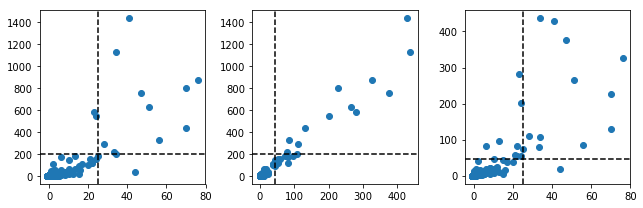

In [5]:
print '%d total files, %d included' %(len(sorted_files), len(included_files))

## Plot the effect of the chosen cutoffs
fig, axes = plt.subplots(1,3, figsize = (9,3))

## scatter values
axes[0].scatter(cancels, negs)
axes[1].scatter(outs, negs)
axes[2].scatter(cancels, outs)

axes[0].axhline(neg_cutoff, c='k', ls='--')
axes[0].axvline(cancel_cutoff, c='k', ls='--')

axes[1].axhline(neg_cutoff, c='k', ls='--')
axes[1].axvline(out_cutoff, c='k', ls='--')

axes[2].axhline(out_cutoff, c='k', ls='--')
axes[2].axvline(cancel_cutoff, c='k', ls='--')

fig.tight_layout()
plt.show()

# Select using experiment dataframe and export

In [6]:
reload(helpers)
reload(bfd)

## NOTE: not currently used for thresholding
min_bout_count = 5
err_thresh = 300

for row in coding.itertuples():
    #print row
    start, rat, cage, duration, drug, dose, adlib, period = row[1:9]
    #row[1], row[2], row[3], row[4], row[5], row[6], row[7], 
    exp_ix = helpers.filter_data(data, cage, start, start + pd.Timedelta(hours=duration))
    
    ## Skip if no data
    if exp_ix[0] == -1:
        print "Missing data for: ", start, rat, cage, duration, drug, dose
        continue 
    exp_data = data.loc[exp_ix] # fetch the indexed data
    filename = exp_data['filename'].unique()[0]
    
    ## Skip if not in inclusion criteria (see above)
    if filename not in included_files:
        continue
    
    ## Export data
    ## Get filename and category
    filename = exp_data['filename'].unique()[0]
    exp_cat = '_'.join([drug,
                        str(dose),
                        adlib,
                        period])
    
    exp_id = '_'.join([drug,
                       str(dose),
                       adlib,
                       period,
                       str(cage),
                       str(duration),
                       filename])
    
    ## Now select the data
    bout_data = exp_data[['f_length',
                          'g_start',
                          'rate',
                          'p_length',
                          'g_end_feeding']]
    
    bout_data = bout_data.as_matrix()
    
    ## Export, creating new dir if necessary
    path = 'new_all_data/' + exp_cat + '/'
    if not os.path.exists(path):
        os.makedirs(path)
    
    np.savetxt(path+exp_id, bout_data, delimiter='\t')

Missing data for:  2015-02-03 19:00:00 2 2 8 Lep 2.0
Missing data for:  2015-02-05 18:53:00 2 2 8 Lep 2.0
Missing data for:  2015-02-24 18:48:00 3 3 8 LiCl 32.0
Missing data for:  2014-11-10 09:15:00 6 2 8 LiCl 16.0
Missing data for:  2014-10-23 09:02:00 6 2 8 LiCl 32.0
Missing data for:  2014-10-30 09:19:00 5 1 8 LiCl 32.0
Missing data for:  2014-10-28 09:02:00 6 2 8 LiCl 64.0
Missing data for:  2014-10-21 09:07:00 6 2 8 PYY 1.5
Missing data for:  2014-10-28 09:01:00 5 1 8 PYY 1.5
Missing data for:  2014-11-04 09:01:00 6 2 8 PYY 7.5
Missing data for:  2014-10-23 09:01:00 5 1 8 PYY 7.5
Missing data for:  2014-11-06 09:17:00 6 2 8 PYY 300.0
Missing data for:  2014-10-30 09:00:00 6 2 8 saline 0.0
